In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    BatchNormalization, Concatenate, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ast

In [ ]:
# Load preprocessed datasets
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_train_processed.csv')

test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_test_processed.csv')

print("✅ Data loaded successfully!")
print(f"Training shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

✅ Data loaded successfully!
Training shape: (10003, 11)
Test shape: (3080, 11)


In [ ]:
# Load tokenizer
with open('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
# Convert tokenized sequences back to arrays
train_sequences = np.array([ast.literal_eval(seq) for seq in train_data['tokenized_sequences']])
test_sequences = np.array([ast.literal_eval(seq) for seq in test_data['tokenized_sequences']])

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")

Training sequences shape: (10003, 14)
Test sequences shape: (3080, 14)


In [ ]:
# Prepare labels for multi-task learning
def prepare_labels(data):
    """Prepare labels for hierarchical multi-task learning"""

    # Category labels (Level 1: 4 classes)
    category_encoder = LabelEncoder()
    category_labels = category_encoder.fit_transform(data['category'])

    # Intent labels (Level 2: 77 classes)
    intent_encoder = LabelEncoder()
    intent_labels = intent_encoder.fit_transform(data['label_text'])

    # Urgency labels (Level 3: 3 classes)
    urgency_encoder = LabelEncoder()
    urgency_labels = urgency_encoder.fit_transform(data['urgency'])

    return {
        'category': category_labels,
        'intent': intent_labels,
        'urgency': urgency_labels
    }, {
        'category_encoder': category_encoder,
        'intent_encoder': intent_encoder,
        'urgency_encoder': urgency_encoder
    }


In [ ]:
# Prepare training labels
train_labels, label_encoders = prepare_labels(train_data)
test_labels, _ = prepare_labels(test_data)

print(f"Category classes: {len(label_encoders['category_encoder'].classes_)}")
print(f"Intent classes: {len(label_encoders['intent_encoder'].classes_)}")
print(f"Urgency classes: {len(label_encoders['urgency_encoder'].classes_)}")

Category classes: 4
Intent classes: 77
Urgency classes: 3


In [ ]:
# Create train/validation split from training data
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    train_sequences, train_labels['category'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

_, _, y_train_intent, y_val_intent = train_test_split(
    train_sequences, train_labels['intent'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

_, _, y_train_urgency, y_val_urgency = train_test_split(
    train_sequences, train_labels['urgency'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

In [ ]:
# Organize training and validation data
train_targets = {
    'category_output': y_train_cat,
    'intent_output': y_train_intent,
    'urgency_output': y_train_urgency
}

val_targets = {
    'category_output': y_val_cat,
    'intent_output': y_val_intent,
    'urgency_output': y_val_urgency
}

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

Training set: 8002 samples
Validation set: 2001 samples


In [ ]:
 #Display category distribution
print(f"\nCategory distribution:")
for i, category in enumerate(label_encoders['category_encoder'].classes_):
    count = np.sum(train_labels['category'] == i)
    print(f"  {category}: {count} samples")


Category distribution:
  Account Management: 1140 samples
  Card Services: 4416 samples
  General Support: 573 samples
  Transfer & Payments: 3874 samples


In [ ]:
import numpy as np
import random
import tensorflow as tf


# Set random seeds for reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#========== Modified Hierarchical 3-Headed Multi-Task Model with Regularization & Adjusted Loss Weights After Evaluation ===========

from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, GlobalAveragePooling1D,
    Concatenate, BatchNormalization, Dropout, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


class Hierarchical3HeadedBankingModel:
    """Hierarchical 3-Headed Multi-Task Neural Network for Banking Automation"""

    def __init__(self, vocab_size, max_length, embedding_dim=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.model = None

    def build_model(self):
        """Build the complete 3-headed hierarchical architecture"""

        print(" Building 3-Headed Hierarchical Architecture...")

        # Input layer
        input_text = Input(shape=(self.max_length,), name='text_input')

        # Shared embedding layer
        embedding = Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_length,
            mask_zero=True,
            name='shared_embedding'
        )(input_text)

        # Shared feature extraction layers
        print("   🔧 Building shared LSTM layers...")
        lstm1 = Bidirectional(
            LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.3),  #  increased the dropout
            name='shared_lstm1'
        )(embedding)

        lstm2 = Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.3),   #  increased the dropout
            name='shared_lstm2'
        )(lstm1)

        # Global pooling
        global_max = GlobalMaxPooling1D(name='global_max')(lstm2)
        global_avg = GlobalAveragePooling1D(name='global_avg')(lstm2)

        shared_features = Concatenate(name='shared_features')([global_max, global_avg])
        shared_features = BatchNormalization(name='shared_batch_norm')(shared_features)
        shared_features = Dropout(0.6, name='shared_dropout')(shared_features)  # ↑ dropout

        # Dense feature representation with L2 regularization
        shared_dense = Dense(128, activation='relu',
                             kernel_regularizer=regularizers.l2(0.001),
                             name='shared_dense')(shared_features)  # reduced the units + L2
        shared_dense = BatchNormalization(name='shared_dense_bn')(shared_dense)
        shared_dense = Dropout(0.5, name='shared_dense_dropout')(shared_dense) #  increased the dropout

        # ============= HEAD 1: CATEGORY CLASSIFICATION =============
        print("   📊 Head 1: Category Classification")
        category_branch = Dense(64, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001),
                                name='category_branch')(shared_dense)  # reduced the units + L2
        category_branch = BatchNormalization(name='category_bn')(category_branch)
        category_branch = Dropout(0.4, name='category_dropout')(category_branch)  #  increased the dropout
        category_features = Dense(32, activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001),
                                  name='category_features')(category_branch)
        category_output = Dense(4, activation='softmax', name='category_output')(category_features)

        # ============= HEAD 2: INTENT CLASSIFICATION =============
        print("   🎯 Head 2: Specialized Intent Classification")

        def intent_branch(name):
            branch = Dense(64, activation='relu',
                           kernel_regularizer=regularizers.l2(0.001),
                           name=f'{name}_branch')(shared_dense)  # reduced the units + L2
            branch = BatchNormalization(name=f'{name}_bn')(branch)
            branch = Dropout(0.4, name=f'{name}_dropout')(branch)  #  increased the dropout
            return Dense(32, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001),
                         name=f'{name}_features')(branch)

        card_features = intent_branch("card")
        account_features = intent_branch("account")
        transfer_features = intent_branch("transfer")
        support_features = intent_branch("support")

        # Combine hierarchical + branches
        hierarchical_context = Concatenate(name='hierarchical_context')([shared_dense, category_features])
        combined_intent_features = Concatenate(name='combined_intent_features')([
            card_features, account_features, transfer_features, support_features
        ])

        intent_context = Concatenate(name='intent_context')([hierarchical_context, combined_intent_features])

        intent_dense = Dense(128, activation='relu',
                             kernel_regularizer=regularizers.l2(0.001),
                             name='intent_dense')(intent_context) # reduced the units + L2
        intent_dense = BatchNormalization(name='intent_bn')(intent_dense)
        intent_dense = Dropout(0.4, name='intent_dropout')(intent_dense)  #  increased the dropout

        intent_final = Dense(64, activation='relu',
                             kernel_regularizer=regularizers.l2(0.001),
                             name='intent_final')(intent_dense)  # # reduced the units + L2
        intent_output = Dense(77, activation='softmax', name='intent_output')(intent_final)

        # ============= HEAD 3: URGENCY CLASSIFICATION =============
        print("   ⚡ Head 3: Urgency Classification with Hierarchical Context")

        urgency_context = Concatenate(name='urgency_context')([
            shared_dense, category_features, intent_dense
        ])

        urgency_branch = Dense(64, activation='relu',
                               kernel_regularizer=regularizers.l2(0.001),
                               name='urgency_branch')(urgency_context)  # reduced the units + L2
        urgency_branch = BatchNormalization(name='urgency_bn')(urgency_branch)
        urgency_branch = Dropout(0.4, name='urgency_dropout')(urgency_branch)  #  increased the dropout

        urgency_features = Dense(32, activation='relu',
                                 kernel_regularizer=regularizers.l2(0.001),
                                 name='urgency_features')(urgency_branch)
        urgency_output = Dense(3, activation='softmax', name='urgency_output')(urgency_features)

        # ============= CREATE MODEL =============
        self.model = Model(
            inputs=input_text,
            outputs=[category_output, intent_output, urgency_output],
            name='Hierarchical3HeadedBankingModel'
        )

        print("Modified 3-Headed Model with L2 & Dropout Built!")
        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile model with updated loss weights"""

        loss_weights = {
            'category_output': 1.0,
            'intent_output': 2.0,
            'urgency_output': 2.0   # increased the urgency weight in order to overcoem the overffitng
        }

        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss={
                'category_output': 'sparse_categorical_crossentropy',
                'intent_output': 'sparse_categorical_crossentropy',
                'urgency_output': 'sparse_categorical_crossentropy'
            },
            loss_weights=loss_weights,
            metrics={
                'category_output': ['accuracy'],
                'intent_output': ['accuracy'],
                'urgency_output': ['accuracy']
            }
        )

        print("Model compiled with updated multi-task optimization!")
        return self.model

    def get_model_summary(self):
        return self.model.summary()


In [ ]:
# ============= BUILD AND COMPILE 3-HEADED MODEL =============

# Model parameters
vocab_size = len(tokenizer.word_index) + 1
max_length = train_sequences.shape[1]

print(f"\n📊 Model Parameters:")
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_length}")
print(f"Embedding dimension: 128")

# Initialize and build 3-headed model
banking_model = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

# Build the architecture
model = banking_model.build_model()

# Compile with 3-headed multi-task optimization
model = banking_model.compile_model(learning_rate=0.001)

# Display model architecture
print("\n" + "="*80)
print("COMPLETE 3-HEADED HIERARCHICAL BANKING MODEL ARCHITECTURE")
print("="*80)
banking_model.get_model_summary()

# Create model visualization
tf.keras.utils.plot_model(
    model,
    to_file='hierarchical_3headed_banking_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=150
)

print(f"\n✅ Complete 3-Headed Hierarchical Banking Model Built!")
print("📊 Architecture Summary:")
print(f"   • Input: Text sequences (length: {max_length})")
print(f"   • Shared Features: Bidirectional LSTM + Dense layers")
print(f"   • Head 1: Category Classification (4 classes)")
print(f"   • Head 2: Intent Classification (77 classes)")
print(f"   • Head 3: Urgency Classification (3 classes)")
print(f"   • Hierarchical Context: Each head uses previous level info")
print(f"   • Total Parameters: {model.count_params():,}")


📊 Model Parameters:
Vocabulary size: 2297
Max sequence length: 14
Embedding dimension: 128
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Modified 3-Headed Model with L2 & Dropout Built!
✅ Model compiled with updated multi-task optimization!

COMPLETE 3-HEADED HIERARCHICAL BANKING MODEL ARCHITECTURE


Model: "Hierarchical3HeadedBankingModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 14, 128)   │    294,016 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 14)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm1        │ (None, 14, 256)   │    263,168 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm2        │ (None, 14, 128)   │    164,352 │ shared_lstm1[0][… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max          │ (None, 128)       │          0 │ shared_lstm2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg          │ (None, 128)       │          0 │ shared_lstm2[0][… │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_features     │ (None, 256)       │          0 │ global_max[0][0], │
│ (Concatenate)       │                   │            │ global_avg[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_batch_norm   │ (None, 256)       │      1,024 │ shared_features[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout      │ (None, 256)       │          0 │ shared_batch_nor… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense        │ (None, 128)       │     32,896 │ shared_dropout[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_bn     │ (None, 128)       │        512 │ shared_dense[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_dropo… │ (None, 128)       │          0 │ shared_dense_bn[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_branch     │ (None, 64)        │      8,256 │ shared_dense_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card_branch (Dense) │ (None, 64)        │      8,256 │ shared_dense_dro… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ account_branch      │ (None, 64)        │      8,256 │ shared_dense_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transfer_branch     │ (None, 64)        │      8,256 │ shared_dense_dro… │
│ (Dense)             │                   │            │                 

 Total params: 880,756 (3.36 MB)

 Trainable params: 878,964 (3.35 MB)

 Non-trainable params: 1,792 (7.00 KB)


✅ Complete 3-Headed Hierarchical Banking Model Built!
📊 Architecture Summary:
   • Input: Text sequences (length: 14)
   • Shared Features: Bidirectional LSTM + Dense layers
   • Head 1: Category Classification (4 classes)
   • Head 2: Intent Classification (77 classes)
   • Head 3: Urgency Classification (3 classes)
   • Hierarchical Context: Each head uses previous level info
   • Total Parameters: 880,756


In [ ]:

# ============= TRAINING CALLBACKS (Updated) =============
callbacks = [
    EarlyStopping(
        monitor='val_loss',          # Monitor overall validation loss
        patience=10,                 # Reduced patience (was 15)
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',          # Use weighted validation loss (instead of intent accuracy)
        factor=0.5,
        patience=5,                  # Can also tighten here (was 7)
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_hierarchical_3headed_banking_model.keras',
        monitor='val_loss',          # Save best model based on overall performance
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]


In [ ]:
# ============= MODEL TRAINING EXECUTION =============

print(f"\n" + "="*80)
print("TRAINING 3-HEADED HIERARCHICAL MULTI-TASK BANKING MODEL")
print("="*80)

print(f"📊 Training Configuration:")
print(f"   • Architecture: 3-headed hierarchical (Category + Intent + Urgency)")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Validation samples: {len(X_val)}")
print(f"   • Loss weights: Category(1.0) + Intent(2.0) + Urgency(2.0)")
print(f"   • Optimizer: Adam with learning rate scheduling")

# Start training
print(f"\n🚀 Starting Training Process...")

try:
    # Train the 3-headed hierarchical multi-task model
    history = model.fit(
        X_train,
        train_targets,
        validation_data=(X_val, val_targets),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n✅ Training Completed Successfully!")

    # Training summary
    final_epoch = len(history.history['loss'])
    best_val_intent_acc = max(history.history['val_intent_output_accuracy'])
    best_val_category_acc = max(history.history['val_category_output_accuracy'])
    best_val_urgency_acc = max(history.history['val_urgency_output_accuracy'])

    print(f"\n📊 Training Summary:")
    print(f"   • Total epochs trained: {final_epoch}")
    print(f"   • Best validation category accuracy: {best_val_category_acc:.4f}")
    print(f"   • Best validation intent accuracy: {best_val_intent_acc:.4f}")
    print(f"   • Best validation urgency accuracy: {best_val_urgency_acc:.4f}")

    # Save training history for analysis
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_history_3headed_V3.csv', index=False)
    print(f"   • Training history saved: training_history_3headed_V3.csv")

except Exception as e:
    print(f"❌ Training Error: {str(e)}")
    print("Please check your data preparation and model configuration.")


TRAINING 3-HEADED HIERARCHICAL MULTI-TASK BANKING MODEL
📊 Training Configuration:
   • Architecture: 3-headed hierarchical (Category + Intent + Urgency)
   • Training samples: 8002
   • Validation samples: 2001
   • Loss weights: Category(1.0) + Intent(2.0) + Urgency(2.0)
   • Optimizer: Adam with learning rate scheduling

🚀 Starting Training Process...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - category_output_accuracy: 0.4344 - category_output_loss: 1.3658 - intent_output_accuracy: 0.0167 - intent_output_loss: 4.5951 - loss: 14.1610 - urgency_output_accuracy: 0.4479 - urgency_output_loss: 1.1957
Epoch 1: val_loss improved from inf to 12.99565, saving model to best_hierarchical_3headed_banking_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 177ms/step - category_output_accuracy: 0.4347 - category_output_loss: 1.3652 - intent_output_accuracy: 0.0167 - intent_output_loss: 4.5946 - loss: 14.1586 - urgency_output_accuracy: 0.4481 - urgency_output_loss: 1.1953 - val_category_output_accuracy: 0.4423 - val_category_output_loss: 1.1633 - val_intent_output_accuracy: 0.0165 - val_intent_output_loss: 4.3285 - val_loss: 12.9956 - val_urgency_output_accuracy: 0.5732 - val_urgency_output_loss: 0.9930 - learning_rate: 0.0010
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - category_output_accuracy: 0.6506 - category_output_loss: 0.9669 - inte

In [ ]:
# ============= SAVE TRAINED MODEL AND COMPONENTS =============
print(f"\n💾 SAVING TRAINED MODEL AND COMPONENTS")
print("-" * 50)

# Define Google Drive save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/'

# Create directory if it doesn't exist
import os
os.makedirs(save_dir, exist_ok=True)

# Save the complete trained model to Google Drive
#model.save(f'{save_dir}hierarchical_3headed_banking_model_complete.h5')
#print("✅ Complete model saved to Google Drive: hierarchical_3headed_banking_model_complete.h5")

# Save the complete trained model to Google Drive in .keras format
model.save(f'{save_dir}hierarchical_3headed_banking_model_complete_V3.keras')
print("✅ Complete model saved to Google Drive: hierarchical_3headed_banking_model_complete_V3.keras")

# Save label encoders to Google Drive
with open(f'{save_dir}label_encoders_3headed_V3.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✅ Label encoders saved to Google Drive: label_encoders_3headed_V3.pkl")

# Save model parameters to Google Drive
import json
model_info = {
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model.count_params(),
    'training_epochs': final_epoch,
    'best_val_category_accuracy': best_val_category_acc,
    'best_val_intent_accuracy': best_val_intent_acc,
    'best_val_urgency_accuracy': best_val_urgency_acc
}

with open(f'{save_dir}model_info_3headed_V3.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("✅ Model info saved to Google Drive: model_info_3headed_V3.json")

# Save training_history_3headed
training_history_3headed_df = pd.DataFrame(history.history)
training_history_3headed_df.to_csv(f'{save_dir}training_3headed_training_history_V3.csv', index=False)
print("✅ advanced_3headed model training history_V3 saved to Google Drive")


# Also copy the training history to Google Drive (if not already there)
#import shutil
#if os.path.exists('training_history_3headed.csv'):
    #shutil.copy('training_history_3headed.csv', f'{save_dir}training_history_3headed.csv')
    #print("✅ Training history copied to Google Drive: training_history_3headed.csv")

print(f"\n✅  All files saved to Google Drive!")
print(f"📁 Files location: {save_dir}")


💾 SAVING TRAINED MODEL AND COMPONENTS
--------------------------------------------------
✅ Complete model saved to Google Drive: hierarchical_3headed_banking_model_complete_V3.keras
✅ Label encoders saved to Google Drive: label_encoders_3headed_V3.pkl
✅ Model info saved to Google Drive: model_info_3headed_V3.json
✅ advanced_3headed model training history_V3 saved to Google Drive

✅  All files saved to Google Drive!
📁 Files location: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [ ]:
from sklearn.metrics import classification_report
#  Get model predictions on validation data
val_preds = model.predict(X_val, batch_size=32)

# Each head returns probability distributions, need argmax for predicted class
pred_category = np.argmax(val_preds[0], axis=1)
pred_intent   = np.argmax(val_preds[1], axis=1)
pred_urgency  = np.argmax(val_preds[2], axis=1)

#  Category classification report
print("===== Category Classification Report =====")
print(classification_report(y_val_cat, pred_category, digits=4))

#  Intent classification report
print("===== Intent Classification Report =====")
print(classification_report(y_val_intent, pred_intent, digits=4))

#  Urgency classification report
print("===== Urgency Classification Report =====")
print(classification_report(y_val_urgency, pred_urgency, digits=4))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
===== Category Classification Report =====
              precision    recall  f1-score   support

           0     0.9298    0.9298    0.9298       228
           1     0.9344    0.9524    0.9434       883
           2     0.8750    0.8522    0.8634       115
           3     0.9527    0.9355    0.9440       775

    accuracy                         0.9375      2001
   macro avg     0.9230    0.9175    0.9202      2001
weighted avg     0.9376    0.9375    0.9375      2001

===== Intent Classification Report =====
              precision    recall  f1-score   support

           0     0.9091    0.8824    0.8955        34
           1     0.9697    0.9412    0.9552        34
           2     0.7368    1.0000    0.8485        14
           3     0.9444    0.9714    0.9577        35
           4     1.0000    0.6667    0.8000        21
           5     0.9310    0.9310    0.9310        29
           6     0.7812    0.5952    0.6757        42
        

# Testing the Model using TEST DATASET and Evaluation of Predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    BatchNormalization, Concatenate, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ast
import json

In [ ]:
# Load preprocessed datasets
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_test_processed.csv')

print(" Data loaded successfully!")
print(f"Test shape: {test_data.shape}")

 Data loaded successfully!
Test shape: (3080, 11)


In [ ]:
# Load tokenizer
with open('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
# Convert tokenized sequences back to arrays
test_sequences = np.array([ast.literal_eval(seq) for seq in test_data['tokenized_sequences']])
print(f"Test sequences shape: {test_sequences.shape}")

Test sequences shape: (3080, 14)


In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/'

#Load the Final advanced 3 headed hierarchical model
advanced_model_V3 = tf.keras.models.load_model(f'{save_dir}hierarchical_3headed_banking_model_complete_V3.keras')
print("Loaded the Final Advanced_Hierarchical_3headed_model ")

# Load model performance info
with open(f'{save_dir}model_info_3headed_V3.json', 'r') as f:
    advanced_info_V3 = json.load(f)
print("Loaded the advanced 3 headed model training info")

#Load the training history
advanced_history_V3 = pd.read_csv(f'{save_dir}training_3headed_training_history_V3.csv')
print("Loaded the FInal Advanced 3 headed model training history")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Loaded the Final Advanced_Hierarchical_3headed_model 
Loaded the advanced 3 headed model training info
Loaded the FInal Advanced 3 headed model training history


In [ ]:
import pickle

# Load the saved encoders
with open('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/label_encoders_3headed_V3.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

print(" Label encoders loaded successfully!")
print("Encoders available:", list(label_encoders.keys()))

 Label encoders loaded successfully!
Encoders available: ['category_encoder', 'intent_encoder', 'urgency_encoder']


In [ ]:
# Extract individual encoders
category_encoder = label_encoders['category_encoder']
intent_encoder = label_encoders['intent_encoder']
urgency_encoder = label_encoders['urgency_encoder']

# Prepare test targets
test_category_encoded = label_encoders['category_encoder'].transform(test_data['category'])
test_intent_encoded = label_encoders['intent_encoder'].transform(test_data['label_text'])
test_urgency_encoded = label_encoders['urgency_encoder'].transform(test_data['urgency'])

# Create test targets dictionary .... This needs to be same as training dataset
test_targets = {
    'category_output': test_category_encoded,
    'intent_output': test_intent_encoded,
    'urgency_output': test_urgency_encoded
}

print(f" Test Data Prepared:")
print(f"   • Test sequences shape: {test_sequences.shape}")
print(f"   • Category classes: {len(category_encoder.classes_)}")
print(f"   • Intent classes: {len(intent_encoder.classes_)}")
print(f"   • Urgency classes: {len(urgency_encoder.classes_)}")
print(f"   • Test samples - Category: {len(test_category_encoded)}")
print(f"   • Test samples - Intent: {len(test_intent_encoded)}")
print(f"   • Test samples - Urgency: {len(test_urgency_encoded)}")

 Test Data Prepared:
   • Test sequences shape: (3080, 14)
   • Category classes: 4
   • Intent classes: 77
   • Urgency classes: 3
   • Test samples - Category: 3080
   • Test samples - Intent: 3080
   • Test samples - Urgency: 3080


In [ ]:
# ============= MODEL PREDICTIONS ON TEST DATA =============

print(f"\n Making predictions on test data...")

# Make predictions
test_predictions = advanced_model_V3.predict(test_sequences, batch_size=32, verbose=1)

# Extract predictions for each head
pred_category = test_predictions[0]  # Category probabilities
pred_intent = test_predictions[1]    # Intent probabilities
pred_urgency = test_predictions[2]   # Urgency probabilities

# Convert to predicted classes
pred_category_classes = np.argmax(pred_category, axis=1)
pred_intent_classes = np.argmax(pred_intent, axis=1)
pred_urgency_classes = np.argmax(pred_urgency, axis=1)

print("Predictions completed!")


 Making predictions on test data...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
Predictions completed!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# ============= COMPREHENSIVE EVALUATION METRICS =============

def evaluate_multiclass_performance(y_true, y_pred, y_pred_proba, class_names, task_name):
    """Comprehensive evaluation for multiclass classification"""

    print(f"\n" + "="*60)
    print(f"{task_name.upper()} CLASSIFICATION RESULTS")
    print("="*60)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"📊 Overall Metrics:")
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • Weighted Precision: {precision:.4f}")
    print(f"   • Weighted Recall: {recall:.4f}")
    print(f"   • Weighted F1-Score: {f1:.4f}")

    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    }

# ============= EVALUATE EACH HEAD SEPARATELY =============

print(f"\n🎯 COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Category Classification Evaluation
category_results = evaluate_multiclass_performance(
    test_targets['category_output'],
    pred_category_classes,
    pred_category,
    category_encoder.classes_,
    "Category"
)

# Intent Classification Evaluation
intent_results = evaluate_multiclass_performance(
    test_targets['intent_output'],
    pred_intent_classes,
    pred_intent,
    intent_encoder.classes_,
    "Intent"
)

# Urgency Classification Evaluation
urgency_results = evaluate_multiclass_performance(
    test_targets['urgency_output'],
    pred_urgency_classes,
    pred_urgency,
    urgency_encoder.classes_,
    "Urgency"
)



🎯 COMPREHENSIVE MODEL EVALUATION

CATEGORY CLASSIFICATION RESULTS
📊 Overall Metrics:
   • Accuracy: 0.9455
   • Weighted Precision: 0.9455
   • Weighted Recall: 0.9455
   • Weighted F1-Score: 0.9454

📋 Detailed Classification Report:
                     precision    recall  f1-score   support

 Account Management     0.9571    0.9306    0.9437       360
      Card Services     0.9456    0.9564    0.9510      1400
    General Support     0.8889    0.8800    0.8844       200
Transfer & Payments     0.9516    0.9482    0.9499      1120

           accuracy                         0.9455      3080
          macro avg     0.9358    0.9288    0.9322      3080
       weighted avg     0.9455    0.9455    0.9454      3080


INTENT CLASSIFICATION RESULTS
📊 Overall Metrics:
   • Accuracy: 0.8140
   • Weighted Precision: 0.8246
   • Weighted Recall: 0.8140
   • Weighted F1-Score: 0.8129

📋 Detailed Classification Report:
                                                  precision    recall  f1-s

In [ ]:
# ============= OVERALL MODEL PERFORMANCE SUMMARY =============

print(f"\n" + "="*80)
print("OVERALL 3-HEADED MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"📊 Test Set Performance:")
print(f"   • Category Head Accuracy: {category_results['accuracy']:.4f}")
print(f"   • Intent Head Accuracy: {intent_results['accuracy']:.4f}")
print(f"   • Urgency Head Accuracy: {urgency_results['accuracy']:.4f}")

print(f"\n📈 Weighted F1-Scores:")
print(f"   • Category Head F1: {category_results['f1_score']:.4f}")
print(f"   • Intent Head F1: {intent_results['f1_score']:.4f}")
print(f"   • Urgency Head F1: {urgency_results['f1_score']:.4f}")

# Calculate overall model performance (weighted average)
overall_accuracy = (category_results['accuracy'] + 2*intent_results['accuracy'] + 2*urgency_results['accuracy']) / 5
overall_f1 = (category_results['f1_score'] + 2*intent_results['f1_score'] + 2*urgency_results['f1_score']) / 5

print(f"\n🎯 Weighted Overall Performance (matching training loss weights):")
print(f"   • Overall Weighted Accuracy: {overall_accuracy:.4f}")
print(f"   • Overall Weighted F1-Score: {overall_f1:.4f}")



OVERALL 3-HEADED MODEL PERFORMANCE SUMMARY
📊 Test Set Performance:
   • Category Head Accuracy: 0.9455
   • Intent Head Accuracy: 0.8140
   • Urgency Head Accuracy: 0.7571

📈 Weighted F1-Scores:
   • Category Head F1: 0.9454
   • Intent Head F1: 0.8129
   • Urgency Head F1: 0.7462

🎯 Weighted Overall Performance (matching training loss weights):
   • Overall Weighted Accuracy: 0.8175
   • Overall Weighted F1-Score: 0.8127


In [ ]:
# ============= DETAILED ERROR ANALYSIS =============

def analyze_prediction_errors(y_true, y_pred, class_names, task_name):
    """Analyze prediction errors in detail"""

    print(f"\n🔍 {task_name} Error Analysis:")

    # Find misclassified samples
    misclassified = y_true != y_pred
    error_count = np.sum(misclassified)
    error_rate = error_count / len(y_true)

    print(f"   • Total errors: {error_count}/{len(y_true)} ({error_rate:.2%})")

    if error_count > 0:
        # Most confused classes
        cm = confusion_matrix(y_true, y_pred)

        # Find most problematic class pairs
        error_pairs = []
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                if i != j and cm[i][j] > 0:
                    error_pairs.append((class_names[i], class_names[j], cm[i][j]))

        # Sort by error frequency
        error_pairs.sort(key=lambda x: x[2], reverse=True)

        print(f"   • Top 5 confused class pairs:")
        for true_class, pred_class, count in error_pairs[:5]:
            print(f"     - {true_class} → {pred_class}: {count} errors")

    return error_count, error_rate

# Perform error analysis for each head
print(f"\n" + "="*60)
print("DETAILED ERROR ANALYSIS")
print("="*60)

category_errors, category_error_rate = analyze_prediction_errors(
    test_targets['category_output'], pred_category_classes,
    category_encoder.classes_, "Category"
)

intent_errors, intent_error_rate = analyze_prediction_errors(
    test_targets['intent_output'], pred_intent_classes,
    intent_encoder.classes_, "Intent"
)

urgency_errors, urgency_error_rate = analyze_prediction_errors(
    test_targets['urgency_output'], pred_urgency_classes,
    urgency_encoder.classes_, "Urgency"
)



DETAILED ERROR ANALYSIS

🔍 Category Error Analysis:
   • Total errors: 168/3080 (5.45%)
   • Top 5 confused class pairs:
     - Transfer & Payments → Card Services: 42 errors
     - Card Services → Transfer & Payments: 41 errors
     - Account Management → Card Services: 21 errors
     - General Support → Card Services: 14 errors
     - Transfer & Payments → General Support: 11 errors

🔍 Intent Error Analysis:
   • Total errors: 573/3080 (18.60%)
   • Top 5 confused class pairs:
     - why_verify_identity → verify_my_identity: 20 errors
     - virtual_card_not_working → get_disposable_virtual_card: 12 errors
     - virtual_card_not_working → getting_virtual_card: 12 errors
     - order_physical_card → getting_spare_card: 10 errors
     - fiat_currency_support → exchange_via_app: 8 errors

🔍 Urgency Error Analysis:
   • Total errors: 748/3080 (24.29%)
   • Top 5 confused class pairs:
     - Normal → Low: 432 errors
     - Low → Normal: 210 errors
     - Critical → Low: 45 errors
     -

In [ ]:
# ============= CONFIDENCE ANALYSIS =============

def analyze_prediction_confidence(predictions, task_name):
    """Analyze prediction confidence distribution"""

    max_probs = np.max(predictions, axis=1)

    print(f"\n📊 {task_name} Prediction Confidence:")
    print(f"   • Mean confidence: {np.mean(max_probs):.4f}")
    print(f"   • Std confidence: {np.std(max_probs):.4f}")
    print(f"   • Min confidence: {np.min(max_probs):.4f}")
    print(f"   • Max confidence: {np.max(max_probs):.4f}")

    # Confidence distribution
    high_conf = np.sum(max_probs > 0.8) / len(max_probs)
    medium_conf = np.sum((max_probs > 0.5) & (max_probs <= 0.8)) / len(max_probs)
    low_conf = np.sum(max_probs <= 0.5) / len(max_probs)

    print(f"   • High confidence (>0.8): {high_conf:.2%}")
    print(f"   • Medium confidence (0.5-0.8): {medium_conf:.2%}")
    print(f"   • Low confidence (≤0.5): {low_conf:.2%}")

    return max_probs

print(f"\n" + "="*60)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*60)

category_confidence = analyze_prediction_confidence(pred_category, "Category")
intent_confidence = analyze_prediction_confidence(pred_intent, "Intent")
urgency_confidence = analyze_prediction_confidence(pred_urgency, "Urgency")


PREDICTION CONFIDENCE ANALYSIS

📊 Category Prediction Confidence:
   • Mean confidence: 0.9777
   • Std confidence: 0.0707
   • Min confidence: 0.3188
   • Max confidence: 1.0000
   • High confidence (>0.8): 96.33%
   • Medium confidence (0.5-0.8): 3.51%
   • Low confidence (≤0.5): 0.16%

📊 Intent Prediction Confidence:
   • Mean confidence: 0.8778
   • Std confidence: 0.1757
   • Min confidence: 0.2091
   • Max confidence: 1.0000
   • High confidence (>0.8): 76.17%
   • Medium confidence (0.5-0.8): 17.95%
   • Low confidence (≤0.5): 5.88%

📊 Urgency Prediction Confidence:
   • Mean confidence: 0.8081
   • Std confidence: 0.1586
   • Min confidence: 0.3871
   • Max confidence: 1.0000
   • High confidence (>0.8): 58.21%
   • Medium confidence (0.5-0.8): 40.10%
   • Low confidence (≤0.5): 1.69%


In [ ]:
# ============= SAVE TEST RESULTS =============

print(f"\n💾 Saving test results...")

# Compile all results
test_results = {
    'model_info': advanced_info_V3,
    'test_data_info': {
        'test_samples': len(test_sequences),
        'vocab_size': len(tokenizer.word_index) + 1,
        'max_length': test_sequences.shape[1]
    },
    'performance': {
        'category': {
            'accuracy': float(category_results['accuracy']),
            'f1_score': float(category_results['f1_score']),
            'precision': float(category_results['precision']),
            'recall': float(category_results['recall'])
        },
        'intent': {
            'accuracy': float(intent_results['accuracy']),
            'f1_score': float(intent_results['f1_score']),
            'precision': float(intent_results['precision']),
            'recall': float(intent_results['recall'])
        },
        'urgency': {
            'accuracy': float(urgency_results['accuracy']),
            'f1_score': float(urgency_results['f1_score']),
            'precision': float(urgency_results['precision']),
            'recall': float(urgency_results['recall'])
        },
        'overall': {
            'weighted_accuracy': float(overall_accuracy),
            'weighted_f1_score': float(overall_f1)
        }
    },
    'confidence_analysis': {
        'category_mean_confidence': float(np.mean(category_confidence)),
        'intent_mean_confidence': float(np.mean(intent_confidence)),
        'urgency_mean_confidence': float(np.mean(urgency_confidence))
    }
}

# Save test results
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/Test_Results/'

with open(f'{save_dir}test_results_3headed_V3.json', 'w') as f:
    json.dump(test_results, f, indent=4)

# Save detailed predictions
test_predictions_df = pd.DataFrame({
    'text': test_data['text'],
    'true_category': test_data['category'],
    'true_intent': test_data['label_text'],
    'true_urgency': test_data['urgency'],
    'pred_category': category_encoder.inverse_transform(pred_category_classes),
    'pred_intent': intent_encoder.inverse_transform(pred_intent_classes),
    'pred_urgency': urgency_encoder.inverse_transform(pred_urgency_classes),
    'category_confidence': category_confidence,
    'intent_confidence': intent_confidence,
    'urgency_confidence': urgency_confidence,
    'category_correct': test_targets['category_output'] == pred_category_classes,
    'intent_correct': test_targets['intent_output'] == pred_intent_classes,
    'urgency_correct': test_targets['urgency_output'] == pred_urgency_classes
})

test_predictions_df.to_csv(f'{save_dir}detailed_test_predictions_V3.csv', index=False)

print("✅ Test results saved successfully!")
print(f"   • Test results: {save_dir}test_results_3headed_V3.json")
print(f"   • Detailed predictions: {save_dir}detailed_test_predictions_V3.csv")



💾 Saving test results...
✅ Test results saved successfully!
   • Test results: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/Test_Results/test_results_3headed_V3.json
   • Detailed predictions: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Final_Model/Test_Results/detailed_test_predictions_V3.csv


In [ ]:
# ============= FINAL SUMMARY =============

print(f"\n" + "="*80)
print("🎯 FINAL TEST EVALUATION SUMMARY")
print("="*80)

print(f"✅ Model Testing Completed Successfully!")
print(f"\n📊 Key Performance Metrics:")
print(f"   • Category Classification: {category_results['accuracy']:.1%} accuracy")
print(f"   • Intent Classification: {intent_results['accuracy']:.1%} accuracy")
print(f"   • Urgency Classification: {urgency_results['accuracy']:.1%} accuracy")
print(f"   • Overall Weighted Performance: {overall_accuracy:.1%} accuracy")

print(f"\n🎯 Model Readiness Assessment:")
if overall_accuracy > 0.85:
    print("   ✅ EXCELLENT - Model ready for production deployment")
elif overall_accuracy > 0.75:
    print("   ⚠️  GOOD - Model suitable for deployment with monitoring")
elif overall_accuracy > 0.65:
    print("   ⚠️  FAIR - Consider additional training or feature engineering")
else:
    print("   ❌ POOR - Model needs significant improvement before deployment")

print(f"\n📋 Next Steps:")
print("   1. Test evaluation completed")
print("   2. Review detailed error analysis")
print("   3. Ready for web application implementation")


print(f"\n" + "="*80)


🎯 FINAL TEST EVALUATION SUMMARY
✅ Model Testing Completed Successfully!

📊 Key Performance Metrics:
   • Category Classification: 94.5% accuracy
   • Intent Classification: 81.4% accuracy
   • Urgency Classification: 75.7% accuracy
   • Overall Weighted Performance: 81.8% accuracy

🎯 Model Readiness Assessment:
   ⚠️  GOOD - Model suitable for deployment with monitoring

📋 Next Steps:
   1. Test evaluation completed
   2. Review detailed error analysis
   3. Ready for web application implementation



# Implementing Explainability

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fb581a56489ad31e19147a69c8c2ff820f9cf0dd5f0b89e7820a0ccbf39b0078
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import lime
import lime.lime_text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#LIME IMPLEMENTATION


# ============= LIME EXPLAINER SETUP =============

class SimpleBankingExplainer:
    """Simple LIME Explainer"""

    def __init__(self, model, tokenizer, label_encoders, max_length):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoders = label_encoders
        self.max_length = max_length

        # Initialize LIME
        self.lime_explainer = lime.lime_text.LimeTextExplainer(
            class_names=None,
            split_expression=r'\W+',
            bow=False,
            random_state=42
        )

    def predict_probabilities(self, texts):
        """
        LIME prediction function - processes text variations
        """
        # preprocessing.......
        processed_texts = []

        for text in texts:
            # Clean text........
            text = str(text).lower()

            # Tokenize using tokenizer.......
            sequence = self.tokenizer.texts_to_sequences([text])

            # Pad using  max_length.......
            padded = pad_sequences(sequence, maxlen=self.max_length, padding='post')
            processed_texts.append(padded[0])

        # Predict using the model.......
        processed_array = np.array(processed_texts)
        predictions = self.model.predict(processed_array, verbose=0)

        return predictions

    def explain_prediction(self, text, head='category', num_features=8):
        """Generate LIME explanation for specific head"""

        # Head mapping
        head_info = {
            'category': {'index': 0, 'encoder': 'category_encoder'},
            'intent': {'index': 1, 'encoder': 'intent_encoder'},
            'urgency': {'index': 2, 'encoder': 'urgency_encoder'}
        }

        encoder = self.label_encoders[head_info[head]['encoder']]
        self.lime_explainer.class_names = list(encoder.classes_)

        # Prediction function for this head only
        def predict_fn(texts):
            all_preds = self.predict_probabilities(texts)
            head_preds = all_preds[head_info[head]['index']]
            return head_preds

        # Generate explanation
        explanation = self.lime_explainer.explain_instance(
            text, predict_fn, num_features=num_features, num_samples=500
        )

        return explanation

print("LIME EXPLAINER SETUP IS COMPLETED")

LIME EXPLAINER SETUP IS COMPLETED


In [ ]:
# ============= INITIALIZing  =============

# Use already-loaded components
explainer = SimpleBankingExplainer(
    model=advanced_model_V3,
    tokenizer=tokenizer,
    label_encoders=label_encoders,
    max_length=test_sequences.shape[1]
)

print("LIME explainer initialized with model components")


LIME explainer initialized with model components


In [ ]:
# ============= TEST ON WITH TEST DATA ============= without the true labels

print(f"TESTING LIME ON TEST SAMPLES")


# Use some of the test data samples directly
sample_indices = [396, 1658, 163, 523, 20]

for i, idx in enumerate(sample_indices):
    if idx >= len(test_data):
        continue

    print(f"\n SAMPLE {i+1}:")
    sample_text = test_data.iloc[idx]['text']
    print(f"Text: {sample_text[:100]}...")

    try:
        # Explain category prediction
        cat_explanation = explainer.explain_prediction(sample_text, head='category')
        print("    Category explanation:")
        for word, importance in cat_explanation.as_list()[:5]:
            print(f"      '{word}': {importance:.3f}")

        # Explain urgency prediction
        urgency_explanation = explainer.explain_prediction(sample_text, head='urgency')
        print("    Urgency explanation:")
        for word, importance in urgency_explanation.as_list()[:3]:
            print(f"      '{word}': {importance:.3f}")

        print("   Explanations generated!")

    except Exception as e:
        print(f"    Error: {str(e)}")


TESTING LIME ON TEST SAMPLES

 SAMPLE 1:
Text: How can i check if my card is working?...
    Category explanation:
      'card': 0.688
      'working': 0.077
      'check': -0.034
      'if': -0.004
      'can': 0.002
    Urgency explanation:
      'check': 0.408
      'working': -0.255
      'card': 0.125
   Explanations generated!

 SAMPLE 2:
Text: I lost my phone and would like to freeze my accounts....
    Category explanation:
      'phone': -0.572
      'freeze': 0.193
      'lost': -0.075
      'like': 0.060
      'would': 0.043
    Urgency explanation:
      'freeze': -0.026
      'phone': -0.025
      'lost': -0.022
   Explanations generated!

 SAMPLE 3:
Text: Why is there an extra dollar charged to my account?...
    Category explanation:
      'dollar': -0.697
      'charged': 0.175
      'extra': 0.055
      'an': -0.028
      'account': -0.018
    Urgency explanation:
      'extra': 0.154
      'charged': 0.154
      'dollar': 0.054
   Explanations generated!

 SAMPLE 4:
T

In [ ]:
# =============  VISUALIZATION FUNCTION =============

def show_explanation(text, head='category'):
    """Quick function to show LIME explanation"""

    explanation = explainer.explain_prediction(text, head=head)
    exp_data = explanation.as_list()

    print(f"\n LIME Explanation - {head.upper()}:")
    print(f"Text: {text}")
    print("Word Importance:")

    for word, importance in exp_data[:8]:
        direction = "promotes" if importance > 0 else "demotes"
        print(f"  '{word}': {importance:.3f} ({direction} prediction)")

    # Simple visualization
    words = [item[0] for item in exp_data[:6]]
    importances = [item[1] for item in exp_data[:6]]

    plt.figure(figsize=(10, 4))
    colors = ['green' if imp > 0 else 'red' for imp in importances]
    plt.barh(range(len(words)), importances, color=colors, alpha=0.7)
    plt.yticks(range(len(words)), words)
    plt.xlabel('LIME Importance Score')
    plt.title(f'Word Importance - {head.upper()} Prediction')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



 VISUALIZATION TEST:

 LIME Explanation - CATEGORY:
Text: I did not get my card yet, is it lost?
Word Importance:
  'card': 0.479 (promotes prediction)
  'yet': 0.274 (promotes prediction)
  'get': -0.074 (demotes prediction)
  'is': -0.032 (demotes prediction)
  'my': -0.019 (demotes prediction)
  'not': -0.018 (demotes prediction)
  'it': 0.013 (promotes prediction)
  'lost': -0.009 (demotes prediction)


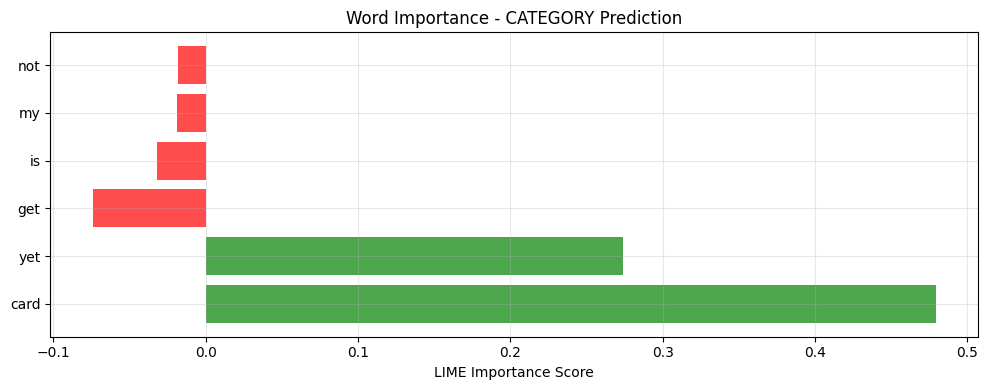


LIME IMPLEMENTATION COMPLETE!


In [ ]:
# ============= TEST THE VISUALIZATION =============

# Test with a sample from your data
if len(test_data) > 0:
    test_text = test_data.iloc[20]['text']
    print(f"\n VISUALIZATION TEST:")
    show_explanation(test_text, head='category')

print(f"\nLIME IMPLEMENTATION COMPLETE!")

Testing with test sample with true label which makes it easy to analyse the result

In [ ]:
# ============= TEST ON WITH TEST DATA =============

print(f"TESTING LIME ON TEST SAMPLES")
print("="*60)

# Use some of the test data samples directly
sample_indices = [396, 1658, 163, 523, 20]

for i, idx in enumerate(sample_indices):
    if idx >= len(test_data):
        continue

    print(f"\n SAMPLE {i+1}:")
    sample_text = test_data.iloc[idx]['text']
    print(f"Text: {sample_text}")

    # ============= SHOW TRUE LABELS FIRST =============
    true_category = test_data.iloc[idx]['category']
    true_intent = test_data.iloc[idx]['label_text']
    true_urgency = test_data.iloc[idx]['urgency']

    print(f"\nTRUE LABELS:")
    print(f"    Category: {true_category}")
    print(f"    Intent: {true_intent}")
    print(f"    Urgency: {true_urgency}")


# ============= GET MODEL PREDICTIONS ============

    try:
        # Get actual model predictions for comparison
        sample_predictions = explainer.predict_probabilities([sample_text])

        # Extract predictions for each head
        pred_category_idx = np.argmax(sample_predictions[0][0])
        pred_intent_idx = np.argmax(sample_predictions[1][0])
        pred_urgency_idx = np.argmax(sample_predictions[2][0])

        # Convert back to labels
        pred_category = label_encoders['category_encoder'].inverse_transform([pred_category_idx])[0]
        pred_intent = label_encoders['intent_encoder'].inverse_transform([pred_intent_idx])[0]
        pred_urgency = label_encoders['urgency_encoder'].inverse_transform([pred_urgency_idx])[0]

        # Get confidence scores
        cat_confidence = sample_predictions[0][0][pred_category_idx]
        intent_confidence = sample_predictions[1][0][pred_intent_idx]
        urgency_confidence = sample_predictions[2][0][pred_urgency_idx]

        print(f"\n🤖 MODEL PREDICTIONS:")
        print(f"    Category: {pred_category} {'✅' if pred_category == true_category else '❌'} (Conf: {cat_confidence:.3f})")
        print(f"    Intent: {pred_intent} {'✅' if pred_intent == true_intent else '❌'} (Conf: {intent_confidence:.3f})")
        print(f"    Urgency: {pred_urgency} {'✅' if pred_urgency == true_urgency else '❌'} (Conf: {urgency_confidence:.3f})")

        # ============= LIME EXPLANATIONS =============
        print(f"\n🔍 LIME EXPLANATIONS:")

        # Explain category prediction
        cat_explanation = explainer.explain_prediction(sample_text, head='category')
        print(f"    Category Explanation (Predicted: {pred_category}):")
        for word, importance in cat_explanation.as_list()[:5]:
            direction = "promotes" if importance > 0 else "demotes"
            print(f"      '{word}': {importance:+.3f} ({direction})")

        # Explain intent prediction
        intent_explanation = explainer.explain_prediction(sample_text, head='intent')
        print(f"    Intent Explanation (Predicted: {pred_intent}):")
        for word, importance in intent_explanation.as_list()[:5]:
            direction = "promotes" if importance > 0 else "demotes"
            print(f"      '{word}': {importance:+.3f} ({direction})")

        # Explain urgency prediction
        urgency_explanation = explainer.explain_prediction(sample_text, head='urgency')
        print(f"    Urgency Explanation (Predicted: {pred_urgency}):")
        for word, importance in urgency_explanation.as_list()[:5]:
            direction = "promotes" if importance > 0 else "demotes"
            print(f"      '{word}': {importance:+.3f} ({direction})")

        # ============= EVALUATION SUMMARY =============
        correct_predictions = sum([
            pred_category == true_category,
            pred_intent == true_intent,
            pred_urgency == true_urgency
        ])

        print(f"\n EVALUATION SUMMARY:")
        print(f"   Correct Predictions: {correct_predictions}/3")
        if correct_predictions == 3:
            print("    ALL CORRECT - Explanations show why model succeeded")
        elif correct_predictions == 0:
            print("    ALL WRONG - Explanations show model confusion")
        else:
            print("    PARTIAL - Explanations show mixed model performance")

        print("    Explanations generated successfully!")

    except Exception as e:
        print(f"   ❌ Error: {str(e)}")

    print("-" * 60)


TESTING LIME ON TEST SAMPLES

 SAMPLE 1:
Text: How can i check if my card is working?

TRUE LABELS:
    Category: Card Services
    Intent: card_not_working
    Urgency: Low

🤖 MODEL PREDICTIONS:
    Category: Card Services ✅ (Conf: 0.967)
    Intent: card_not_working ✅ (Conf: 0.976)
    Urgency: Normal ❌ (Conf: 0.516)

🔍 LIME EXPLANATIONS:
    Category Explanation (Predicted: Card Services):
      'card': +0.695 (promotes)
      'working': +0.086 (promotes)
      'check': -0.024 (demotes)
      'i': +0.013 (promotes)
      'if': -0.005 (demotes)
    Intent Explanation (Predicted: card_not_working):
      'working': -0.000 (demotes)
      'card': +0.000 (promotes)
      'check': +0.000 (promotes)
      'i': +0.000 (promotes)
      'is': +0.000 (promotes)
    Urgency Explanation (Predicted: Normal):
      'check': +0.397 (promotes)
      'working': -0.217 (demotes)
      'card': +0.129 (promotes)
      'i': -0.016 (demotes)
      'if': -0.011 (demotes)

 EVALUATION SUMMARY:
   Correct P

In [ ]:
# ============= TEST ON WITH TEST DATA =============

print(f"TESTING LIME ON TEST SAMPLES")
print("="*60)

# Use some of the test data samples directly
sample_indices = [396, 1658, 163, 523, 20]

for i, idx in enumerate(sample_indices):
    if idx >= len(test_data):
        continue

    print(f"\n SAMPLE {i+1}:")
    sample_text = test_data.iloc[idx]['text']
    print(f"Text: {sample_text}")

    # ============= SHOW TRUE LABELS FIRST =============
    true_category = test_data.iloc[idx]['category']
    true_intent = test_data.iloc[idx]['label_text']
    true_urgency = test_data.iloc[idx]['urgency']

    print(f"\nTRUE LABELS:")
    print(f"    Category: {true_category}")
    print(f"    Intent: {true_intent}")
    print(f"    Urgency: {true_urgency}")


# ============= GET MODEL PREDICTIONS ============

    try:
        # Get actual model predictions for comparison
        sample_predictions = explainer.predict_probabilities([sample_text])

        # Extract predictions for each head
        pred_category_idx = np.argmax(sample_predictions[0][0])
        pred_intent_idx = np.argmax(sample_predictions[1][0])
        pred_urgency_idx = np.argmax(sample_predictions[2][0])

        # Convert back to labels
        pred_category = label_encoders['category_encoder'].inverse_transform([pred_category_idx])[0]
        pred_intent = label_encoders['intent_encoder'].inverse_transform([pred_intent_idx])[0]
        pred_urgency = label_encoders['urgency_encoder'].inverse_transform([pred_urgency_idx])[0]

        # Get confidence scores
        cat_confidence = sample_predictions[0][0][pred_category_idx]
        intent_confidence = sample_predictions[1][0][pred_intent_idx]
        urgency_confidence = sample_predictions[2][0][pred_urgency_idx]

        print(f"\n MODEL PREDICTIONS:")
        print(f"    Category: {pred_category} {'✅' if pred_category == true_category else '❌'} (Conf: {cat_confidence:.3f})")
        print(f"    Intent: {pred_intent} {'✅' if pred_intent == true_intent else '❌'} (Conf: {intent_confidence:.3f})")
        print(f"    Urgency: {pred_urgency} {'✅' if pred_urgency == true_urgency else '❌'} (Conf: {urgency_confidence:.3f})")

        # ============= LIME EXPLANATIONS =============
        print(f"\n LIME EXPLANATIONS:")

        # Explain category prediction
        cat_explanation = explainer.explain_prediction(sample_text, head='category')
        print(f"    Category Explanation (Predicted: {pred_category}):")
        for word, importance in cat_explanation.as_list()[:5]:
            direction = "promotes" if importance > 0 else "demotes"
            print(f"      '{word}': {importance:+.3f} ({direction})")

        # Explain intent prediction
        intent_explanation = explainer.explain_prediction(sample_text, head='intent')
        print(f"    Intent Explanation (Predicted: {pred_intent}):")
        for word, importance in intent_explanation.as_list()[:5]:
            direction = "promotes" if importance > 0 else "demotes"
            print(f"      '{word}': {importance:+.3f} ({direction})")

        # Explain urgency prediction
        urgency_explanation = explainer.explain_prediction(sample_text, head='urgency')
        print(f"    Urgency Explanation (Predicted: {pred_urgency}):")
        for word, importance in urgency_explanation.as_list()[:5]:
            direction = "promotes" if importance > 0 else "demotes"
            print(f"      '{word}': {importance:+.3f} ({direction})")

        # ============= EVALUATION SUMMARY =============
        correct_predictions = sum([
            pred_category == true_category,
            pred_intent == true_intent,
            pred_urgency == true_urgency
        ])

        print(f"\n EVALUATION SUMMARY:")
        print(f"   Correct Predictions: {correct_predictions}/3")
        if correct_predictions == 3:
            print("    ALL CORRECT - Explanations show why model succeeded")
        elif correct_predictions == 0:
            print("    ALL WRONG - Explanations show model confusion")
        else:
            print("    PARTIAL - Explanations show mixed model performance")

        print("    Explanations generated successfully!")

    except Exception as e:
        print(f"   ❌ Error: {str(e)}")

    print("-" * 60)

TESTING LIME ON TEST SAMPLES

 SAMPLE 1:
Text: How can i check if my card is working?

TRUE LABELS:
    Category: Card Services
    Intent: card_not_working
    Urgency: Low

 MODEL PREDICTIONS:
    Category: Card Services ✅ (Conf: 0.967)
    Intent: card_not_working ✅ (Conf: 0.976)
    Urgency: Normal ❌ (Conf: 0.516)

 LIME EXPLANATIONS:
    Category Explanation (Predicted: Card Services):
      'card': +0.681 (promotes)
      'working': +0.067 (promotes)
      'check': -0.032 (demotes)
      'can': +0.007 (promotes)
      'is': +0.005 (promotes)
    Intent Explanation (Predicted: card_not_working):
      'working': -0.000 (demotes)
      'card': +0.000 (promotes)
      'check': +0.000 (promotes)
      'i': +0.000 (promotes)
      'can': +0.000 (promotes)
    Urgency Explanation (Predicted: Normal):
      'check': +0.403 (promotes)
      'working': -0.240 (demotes)
      'card': +0.124 (promotes)
      'How': +0.011 (promotes)
      'my': -0.007 (demotes)

 EVALUATION SUMMARY:
   Corr